In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import linregress

nba_df= pd.read_csv("Resources/shot_logs.csv")


In [76]:
nba_df

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,5,3,1:52,18.3,5,...,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,6,4,11:28,19.8,4,...,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,7,4,11:10,23.0,2,...,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,8,4,2:37,9.1,4,...,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [77]:
#id unique shooters, and count
nba_shooter= nba_df['player_name'].unique()
print(len(nba_shooter))
name_check= nba_df['CLOSEST_DEFENDER_PLAYER_ID'].unique()
print(len(name_check))

grouped_def_df=nba_df.groupby("CLOSEST_DEFENDER_PLAYER_ID")
#convert all NaN in Shot_clock category to game_clock
#drop columns
cleaned_df= nba_df.drop(columns=["MATCHUP", "LOCATION", "DRIBBLES", "TOUCH_TIME"])
cleaned_df

281
474


,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [ ]:
#convert all NaN in Shot_clock category to game_clock

In [79]:
#rename player_name and player_id to fit all caps style
cleaned_df.rename(columns={"player_name": "PLAYER_NAME",
                  "player_id": "PLAYER_ID"})

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [80]:
#convert all NaN in Shot_clock category to game_clock
# cleaned_df["SHOT_CLOCK"].fillna(cleaned_df["GAME_CLOCK"], inplace=True)
cleaned_df

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [81]:
cleaned_df.dtypes

GAME_ID                         int64
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

In [7]:
# to_clean= cleaned_df["GAME_CLOCK"].str.split(":",expand=True).astype(int)
# cleaned_df["GAME_CLOCK_SECONDS"]=to_clean[0]*60 + to_clean[1]
# counter= 0
# cleaned_df["TOTAL_TIME_SECONDS"] = ""
# for index,rows in cleaned_df.iterrows(): 
#     multiplier= 0
#     if rows["PERIOD"] == 1:
#         multiplier= 36*60
#     elif rows["PERIOD"] == 2:
#         multiplier= 24*60
#     elif rows["PERIOD"] == 3:
#         multiplier= 12*60
#     cleaned_df.loc[index,["TOTAL_TIME_SECONDS"]]=multiplier+cleaned_df["GAME_CLOCK_SECONDS"][index]

# cleaned_df.head()

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,GAME_CLOCK_SECONDS,TOTAL_TIME_SECONDS
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,69,2229
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,14,2174
2,21400899,W,24,3,1,0:00,0:00,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,0,2160
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,707,2147
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,634,2074


In [8]:
cleaned_df.to_csv("Resources/Final_nba_df.csv")

In [118]:
cleaned_df

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [128]:
closest_defender = cleaned_df.groupby(["CLOSEST_DEFENDER"])
closest_defender2 = closest_defender["CLOSEST_DEFENDER"].unique()
# closest_defender.head()
defender_count = closest_defender["CLOSEST_DEFENDER"].count()
# defender_count
defender_failure = closest_defender["FGM"].sum()
defender_success = defender_count - defender_failure
success_rate = defender_success / defender_count

defender_df = pd.DataFrame({
    "No. of Times Closest Defender": defender_count,
    "No. of FG made against": defender_failure,
    "No. of successful defenses": defender_success,
    "Success Rate": success_rate
})

defender_df

,No. of Times Closest Defender,No. of FG made against,No. of successful defenses,Success Rate
CLOSEST_DEFENDER,,,,
"Acy, Quincy",276,118,158,0.572464
"Adams, Jordan",30,16,14,0.466667
"Adams, Steven",484,215,269,0.555785
"Adrien, Jeff",73,40,33,0.452055
"Afflalo, Arron",458,191,267,0.582969
...,...,...,...,...
"Young, James",56,27,29,0.517857
"Young, Nick",208,80,128,0.615385
"Young, Thaddeus",532,256,276,0.518797


In [133]:
# find all the different timepoints
shot_clock_timepoints = cleaned_df.groupby(["SHOT_CLOCK"])
shot_clock_remaining = shot_clock_timepoints["SHOT_CLOCK"].unique()
# calculate number of shots at each timepoint
shot_clock_shots = shot_clock_timepoints["SHOT_CLOCK"].count()
# calculate number of shots made at each timepoint
shots_made = shot_clock_timepoints["FGM"].sum()
# calculate FG % at each timepoint
fg_percent = shots_made / shot_clock_shots * 100

# make a new dataframe for graphing
graph_df = pd.DataFrame({
    "Shot Clock": shot_clock_remaining,
    "FG Attempts": shot_clock_shots,
    "FGs Made": shots_made,
    "FG%": fg_percent
})

graph_df

,Shot Clock,FG Attempts,FGs Made,FG%
SHOT_CLOCK,,,,
0.0,[0.0],78,15,19.230769
0.1,[0.1],67,21,31.343284
0.2,[0.2],64,12,18.750000
0.3,[0.3],71,13,18.309859
0.4,[0.4],88,20,22.727273
...,...,...,...,...
23.6,[23.6],147,74,50.340136
23.7,[23.7],128,60,46.875000
23.8,[23.8],112,46,41.071429


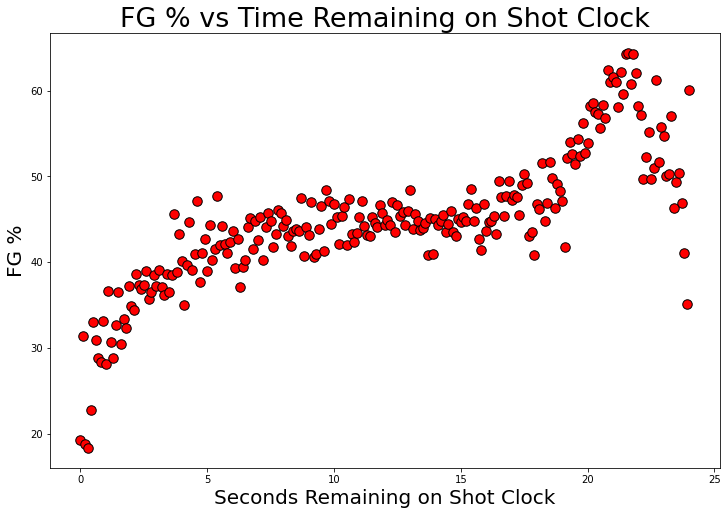

In [134]:
fig1, ax1 = plt.subplots(figsize=(12, 8))
plt.scatter(graph_df["Shot Clock"], graph_df["FG%"], marker="o", s=90, c="r", edgecolor="k")
# plt.invert_xaxis()
# add labels for readability
plt.title("FG % vs Time Remaining on Shot Clock", fontsize=27)
plt.xlabel("Seconds Remaining on Shot Clock", fontsize=20)
plt.ylabel("FG %", fontsize=20)

plt.show()

In [92]:
two_pointer = cleaned_df.loc[cleaned_df["PTS_TYPE"] <= 2]
three_pointer = cleaned_df.loc[cleaned_df["PTS_TYPE"] > 2]

In [94]:
two_pointer

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
5,21400899,W,24,6,2,8:15,9.1,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [95]:
three_pointer

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
8,21400899,W,24,9,4,5:14,12.4,24.6,3,missed,"Morris, Darius",202721,7.3,0,0,brian roberts,203148
9,21400890,W,1,1,2,11:32,17.4,22.4,3,missed,"Ellington, Wayne",201961,19.8,0,0,brian roberts,203148
10,21400890,W,1,2,2,6:30,16.0,24.5,3,missed,"Lin, Jeremy",202391,4.7,0,0,brian roberts,203148
13,21400882,W,15,1,4,9:10,4.4,26.4,3,missed,"Green, Willie",2584,4.4,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128009,21400138,L,-10,4,3,0:40,16.0,25.9,3,missed,"McCollum, CJ",203468,1.8,0,0,jarrett jack,101127
128016,21400138,L,-10,11,4,0:34,21.1,23.0,3,missed,"Crabbe, Allen",203459,1.7,0,0,jarrett jack,101127
128031,21400116,L,-8,4,4,4:19,14.0,23.8,3,missed,"Thomas, Isaiah",202738,2.8,0,0,jarrett jack,101127
128057,21400033,W,12,2,2,10:02,7.3,22.1,3,missed,"Augustin, D.J.",201571,2.9,0,0,jarrett jack,101127


In [131]:
# find all the different timepoints
shot_clock_timepoints2 = two_pointer.groupby(["SHOT_CLOCK"])
shot_clock_remaining2 = shot_clock_timepoints2["SHOT_CLOCK"].unique()
# calculate number of shots at each timepoint
shot_clock_shots2 = shot_clock_timepoints2["SHOT_CLOCK"].count()
# calculate number of shots made at each timepoint
shots_made2 = shot_clock_timepoints2["FGM"].sum()
# calculate FG % at each timepoint
fg_percent2 = shots_made2 / shot_clock_shots2 * 100

# make a new dataframe for graphing
graph_df2 = pd.DataFrame({
    "Shot Clock": shot_clock_remaining2,
    "FG Attempts": shot_clock_shots2,
    "FGs Made": shots_made2,
    "FG%": fg_percent2
})

graph_df2

,Shot Clock,FG Attempts,FGs Made,FG%
SHOT_CLOCK,,,,
0.0,[0.0],47,7,14.893617
0.1,[0.1],48,16,33.333333
0.2,[0.2],40,8,20.000000
0.3,[0.3],48,8,16.666667
0.4,[0.4],49,14,28.571429
...,...,...,...,...
23.6,[23.6],138,72,52.173913
23.7,[23.7],125,59,47.200000
23.8,[23.8],108,43,39.814815


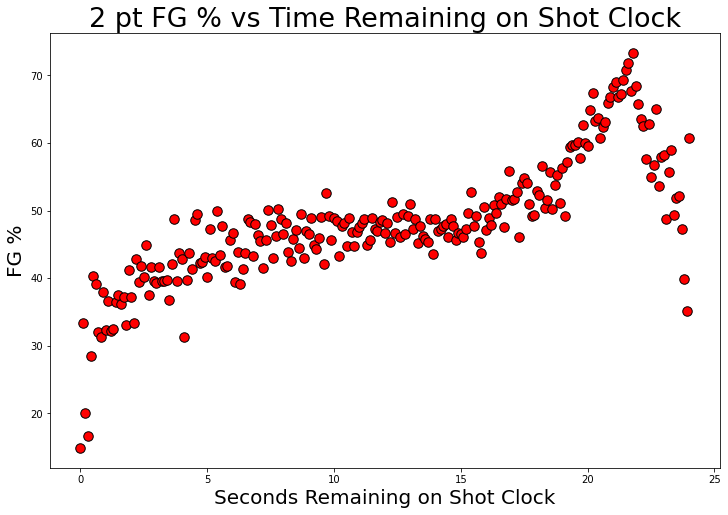

In [132]:
fig1, ax1 = plt.subplots(figsize=(12, 8))
x_value = graph_df2["Shot Clock"]
y_value = graph_df2["FG%"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
# regress_values = x_value * slope + intercept

# line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_value, y_value, s=90, c="r", edgecolor="k")

# # plot regression line
# plt.plot(x_value, regress_values, "b-")

# # print equation in graph
# plt.annotate(line_eq, (0,0), fontsize=20, color="r")

# add labels for readibility
plt.title("2 pt FG % vs Time Remaining on Shot Clock", fontsize=27)
plt.xlabel("Seconds Remaining on Shot Clock", fontsize=20)
plt.ylabel("FG %", fontsize=20)

plt.show()

In [129]:
# find all the different timepoints
shot_clock_timepoints3 = three_pointer.groupby(["SHOT_CLOCK"])
shot_clock_remaining3 = shot_clock_timepoints3["SHOT_CLOCK"].unique()
# calculate number of shots at each timepoint
shot_clock_shots3 = shot_clock_timepoints3["SHOT_CLOCK"].count()
# calculate number of shots made at each timepoint
shots_made3 = shot_clock_timepoints3["FGM"].sum()
# calculate FG % at each timepoint
fg_percent3 = shots_made3 / shot_clock_shots3 * 100

# make a new dataframe for graphing
graph_df3 = pd.DataFrame({
    "Shot Clock": shot_clock_remaining3,
    "FG Attempts": shot_clock_shots3,
    "FGs Made": shots_made3,
    "FG%": fg_percent3
})

graph_df3

,Shot Clock,FG Attempts,FGs Made,FG%
SHOT_CLOCK,,,,
0.0,[0.0],31,8,25.806452
0.1,[0.1],19,5,26.315789
0.2,[0.2],24,4,16.666667
0.3,[0.3],23,5,21.739130
0.4,[0.4],39,6,15.384615
...,...,...,...,...
23.5,[23.5],11,2,18.181818
23.6,[23.6],9,2,22.222222
23.7,[23.7],3,1,33.333333


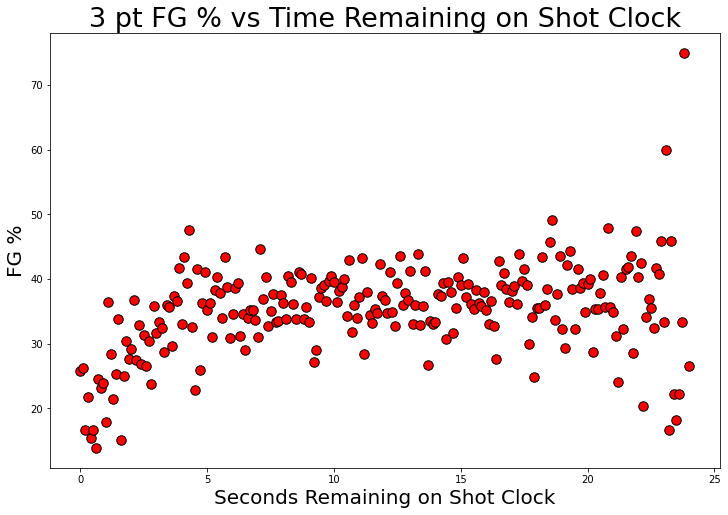

In [130]:
fig1, ax1 = plt.subplots(figsize=(12, 8))
x_value = graph_df3["Shot Clock"]
y_value = graph_df3["FG%"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
# regress_values = x_value * slope + intercept

# line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_value, y_value, s=90, c="r", edgecolor="k")

# # plot regression line
# plt.plot(x_value, regress_values, "b-")

# # print equation in graph
# plt.annotate(line_eq, (0,0), fontsize=20, color="r")

# add labels for readibility
plt.title("3 pt FG % vs Time Remaining on Shot Clock", fontsize=27)
plt.xlabel("Seconds Remaining on Shot Clock", fontsize=20)
plt.ylabel("FG %", fontsize=20)

plt.show()